### 0.Imports and setups

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('20200124_ews_observations.csv',sep = ',',
                low_memory=False,index_col=1,parse_dates=[1])

In [3]:
df.head()

,PatientId,EwsProcedure,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
ObservationDate,,,,,,,,,,,,,,,,,
2019-05-01 13:27:50,29,NEWS2,0,143.0,0.0,ALERT,0,96.0,0.0,False,0.0,80,0,18,0,36.6,0
2019-05-01 15:27:44,30,NEWS2,3,NaN,NaN,ALERT,0,94.0,1.0,False,0.0,83,0,16,0,36.5,0
2019-05-01 15:54:27,31,NEWS2,1,117.0,0.0,ALERT,0,95.0,1.0,False,0.0,75,0,14,0,37.3,0
2019-05-01 16:07:27,32,NEWS2,0,NaN,NaN,ALERT,0,98.0,0.0,False,0.0,85,0,19,0,37.2,0
2019-05-01 17:03:16,33,NEWS2,0,135.0,0.0,ALERT,0,97.0,0.0,False,0.0,89,0,14,0,36.1,0


### 1. Selecting a Patient for modelling

In [4]:
patient = df[df.PatientId == 1743]

In [5]:
patient.index = pd.DatetimeIndex(patient.index).to_period('D')

In [6]:
patient.dropna(inplace=True)

In [7]:
patient.isnull().sum()

PatientId       0
EwsProcedure    0
EWS_Total       0
SBP             0
SBP_Score       0
LOC             0
LOC_Score       0
SpO2            0
SpO2_Score      0
Add_O2          0
Add_O2_Score    0
HR              0
HR_Score        0
RR              0
RR_Score        0
TEMP            0
TEMP_Score      0
dtype: int64

# 2. Stationarity Check

### 2.1 visual plots

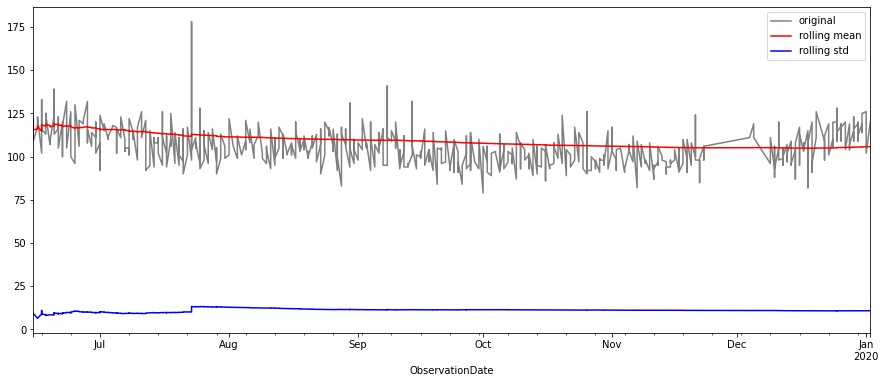

In [8]:
original = patient.SBP.plot(color='gray',label='original')
rolling_mean = patient.SBP.rolling(window='D').mean().plot(color='red',label='rolling mean')
rolling_std = patient.SBP.rolling(window='D').std().plot(color='blue',label='rolling std')
plt.legend()

### 2.2 Dickey-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [10]:
adf(patient.SBP)

Results of Dickey-Fuller Test:


Test Statistic                  -2.812073
p-value                          0.056570
#Lags Used                      14.000000
Number of Observations Used    601.000000
Critical Value (1%)             -3.441278
Critical Value (5%)             -2.866361
Critical Value (10%)            -2.569338
dtype: float64

# 3 Selecting Model 
## 3.0 ACF and PACF plots:

In [11]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(patient.SBP, nlags=50)
lag_pacf = pacf(patient.SBP, nlags=50, method='ols')

### 3.1 Plotting ACF 'AutoCorrelationFunction'

Text(0.5, 1.0, 'Autocorrelation Function')

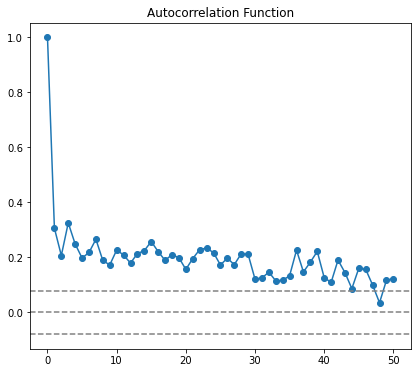

In [12]:
plt.subplot(121) 
plt.plot(lag_acf,marker='o')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(patient.SBP)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(patient.SBP)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

### 3.2 Plotting PACF 'PartialCorrelationFunction'

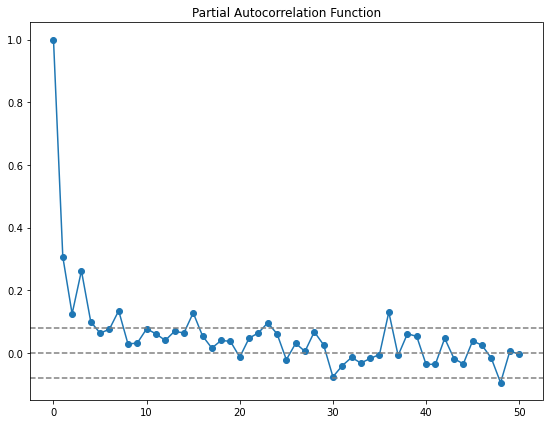

In [13]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, marker='o')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(patient.SBP)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(patient.SBP)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# 4 Arima Model

### 4.0 Grid 'AIC' search for perfect (p,q) 

In [41]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = ARIMA(patient.SBP, order=(p,0,q))
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan

In [42]:
aic_full

,0,1,2,3,4,5
0,0.000000,4634.491699,4633.480179,4602.115809,4595.184326,4594.034310
1,4624.314139,4542.624429,4541.038042,4539.059007,NaN,NaN
2,4616.719373,4541.606957,4536.369375,4537.920372,NaN,NaN
3,4575.100626,4540.671359,4537.822753,4539.491877,NaN,NaN
4,4570.980228,4534.656197,4536.605126,4541.725132,4535.294327,NaN
5,4570.549741,4573.459748,4538.321689,4541.622768,4537.071744,4545.846342


Text(0.5, 1.0, 'RMSE: 9.4610')

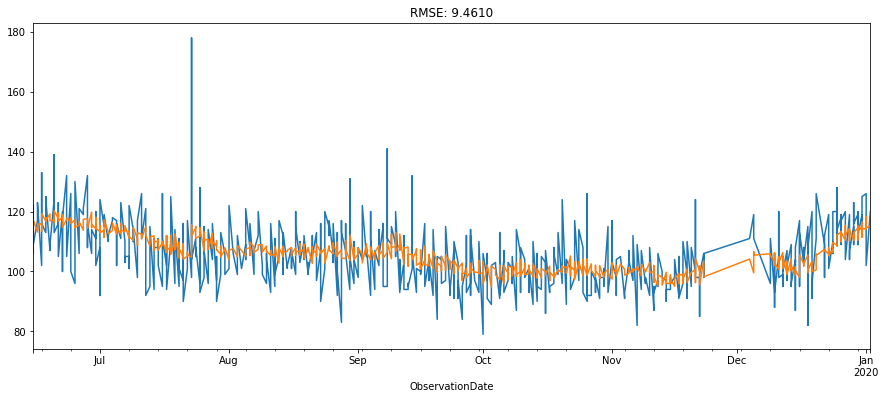

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
model = ARIMA(patient.SBP, order=(4, 0, 4)) 
results_AR = model.fit()  
patient.SBP.plot()
results_AR.fittedvalues.plot()
plt.title('RMSE: %.4f'% sqrt(mean_squared_error(patient.SBP,results_AR.fittedvalues)))

In [25]:
train = patient.SBP[:round(len(patient.SBP)*85/100)]
test = patient.SBP[round(len(patient.SBP)*85/100):]

In [26]:
train

ObservationDate
2019-06-15    122.0
2019-06-15    109.0
2019-06-16    117.0
2019-06-16    123.0
2019-06-17    102.0
              ...  
2019-12-13    104.0
2019-12-13    102.0
2019-12-14    109.0
2019-12-14     95.0
2019-12-14     95.0
Freq: D, Name: SBP, Length: 524, dtype: float64

In [27]:
test

ObservationDate
2019-12-14     95.0
2019-12-14    100.0
2019-12-14     96.0
2019-12-15    104.0
2019-12-15     87.0
              ...  
2020-01-01    120.0
2020-01-01    116.0
2020-01-01    116.0
2020-01-01    102.0
2020-01-02    120.0
Freq: D, Name: SBP, Length: 92, dtype: float64

In [28]:
model2 = ARIMA(train,order=(4,0,4))
result2 = model2.fit(disp=-1)
result2.predict(start=524,end=612)

2020-11-20    103.006316
2020-11-21    105.119072
2020-11-22    105.600873
2020-11-23    104.311239
2020-11-24    105.733815
                 ...    
2021-02-12    108.213061
2021-02-13    107.072384
2021-02-14    108.708714
2021-02-15    108.722899
2021-02-16    107.076976
Freq: D, Length: 89, dtype: float64

In [32]:
from pandas.tseries.offsets import DateOffset
future_dates=[patient.SBP.index[-1] + DateOffset(n=x)for x in range(1,3)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

IncompatibleFrequency: Input has different freq=<DateOffset> from Period(freq=D)

In [ ]:
result2.plot_predict(482)
train.plot()